In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

seed = 2023
random.seed(seed)
np.random.seed(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import torch
import gc

torch.manual_seed(seed)

sns.set_theme()
sns.set_context("paper")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)

%load_ext autoreload
%autoreload 2

# Initialization 

Creation of the data loader and of the agent. Construction of the list containing training steps. 

In [2]:
save_figs = True
small_data = False
data = DataLoader(small_data)
# agent = Agent(data)
agent = Agent(
    data,
    level=2,
    relative=True,
    squared=False,
    initial_lr=5e-3,
    n_modes=10,
    width=20,
    batch_size=32,
    pad_prop=0.05,
    pad_mode="reflect",
    l2_lambda=1e-3,
)
model = agent.model
device = agent.device

models_repo = "./models_H2"
images_repo = "./images_H2"
best_model = torch.load(f"{models_repo}/best_model.pkl")

print(f"Best epoch = {best_model['epoch']}")
if not (os.path.exists(f"{images_repo}/")) and save_figs:
    os.makedirs(f"{images_repo}/")

epochs = [50, 100, 250, 500, 750, 1000, 1250, 1500, 2000, best_model["epoch"]]
print(len(epochs))
print(epochs)

indices = list(range(0, len(epochs)))
size_per_fig = 4
nb_rows = 2
size_row = int(len(indices) / nb_rows)

data_size,nb_val,nb_train: 1800 300 1500
data shape: (None, 3, 64, 64)
Best epoch = 1995
10
[50, 100, 250, 500, 750, 1000, 1250, 1500, 2000, 1995]


# Minimal error on the validation sample

We compute the $L^2$ relative error of each prediction on the validation sample and determine the minimal error. We represent the data, the prediction and the ground truth. 

In [3]:
def compute_L2_norm_squared(U, domain):
    nb_vertices = torch.sum(domain, (1, 2), False)
    norm = (1.0 / nb_vertices) * torch.sum(U**2 * domain, (1, 2), False)
    return norm


def compute_Linf_norm(U, domain):
    norm = torch.amax(torch.abs(U * domain), (1, 2))
    return norm

73
[73]


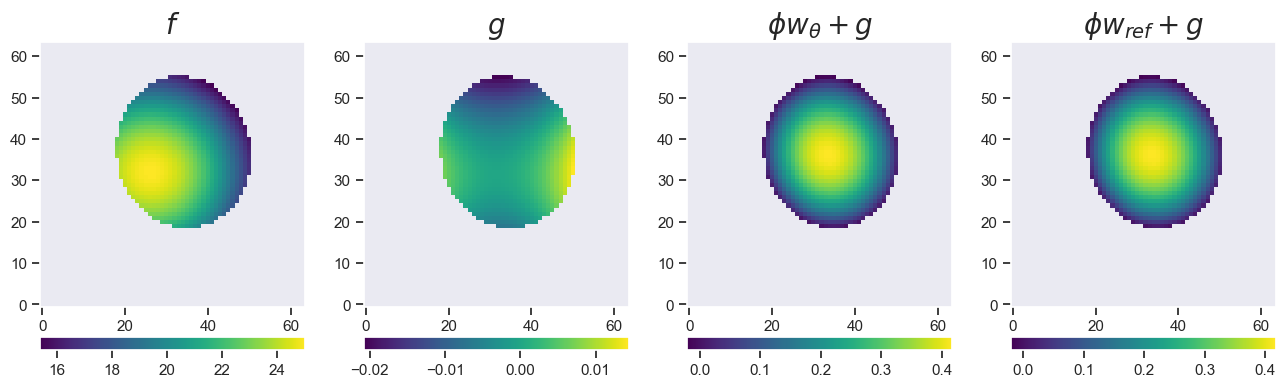

1.568e-04


In [4]:
model = None  # clear memory
X_val, Y_val, x_normed, Y_pred, Y_pred_normed, X_val_normed = (
    None,
    None,
    None,
    None,
    None,
    None,
)
Phi, G, domain, U_true, U_pred = None, None, None, None, None
error, magnitude, error_inf, magnitude_inf = None, None, None, None
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing


model = agent.model
best_model = torch.load(f"{models_repo}/best_model.pkl")
model.load_state_dict(best_model["model_state_dict"])
model.eval()

X_val, Y_val = data.X_val.to(device), data.Y_val.to(device)
X_val_normed = data.X_val_normed.to(device)
Y_pred_normed = model(X_val_normed)
Y_pred = data.y_normalizer.decode(Y_pred_normed)
Phi, G = X_val[:, 1, :, :], X_val[:, 2, :, :]
domain = (Phi <= 3e-16).to(device)


U_true = Y_val[:, 0, :, :] * Phi + G
U_pred = Y_pred[:, 0, :, :] * Phi + G

error = compute_L2_norm_squared((U_pred - U_true), domain)
magnitude = compute_L2_norm_squared((U_true), domain)
L2_error = torch.sqrt(error / magnitude)

L2_error = L2_error.cpu().detach().numpy()
argmin = np.argmin(L2_error)
print(argmin)
sorted_min = sorted(range(len(L2_error)), key=lambda k: L2_error[k])
minimal_errors = sorted_min[:1]
print(minimal_errors)

for i in minimal_errors:
    model = None  # clear memory
    X_val, Y_val, x_normed, Y_pred, Y_pred_normed, X_val_normed = (
        None,
        None,
        None,
        None,
        None,
        None,
    )
    Phi, G, domain, U_true, U_pred = None, None, None, None, None
    error, magnitude, error_inf, magnitude_inf = None, None, None, None
    gc.collect()
    torch.cuda.empty_cache()  # PyTorch thing

    model = agent.model
    best_model = torch.load(f"{models_repo}/best_model.pkl")
    model.load_state_dict(best_model["model_state_dict"])
    model.eval()
    X = data.X_val[i]
    X = X[None, :, :, :].to(device)
    X_normed = data.x_normalizer.encode(X)
    W_ref = data.Y_val[i].cpu().detach().numpy()
    Y_pred_normed = model(X_normed)
    Y_pred = data.y_normalizer.decode(Y_pred_normed).cpu().detach().numpy()
    F, Phi, G = (
        X[0, 0, :, :].cpu().detach().numpy(),
        X[0, 1, :, :].cpu().detach().numpy(),
        X[0, 2, :, :].cpu().detach().numpy(),
    )
    domains = Phi <= 3e-16
    domains_tmp = domains.flatten()
    domains_nan = domains.copy().flatten().astype(float)
    domains_nan[np.where(domains_tmp == False)] = np.nan
    domains_nan = np.reshape(domains_nan, domains.shape)
    plt.figure(figsize=(16, 4))

    ax1 = plt.subplot(141)
    img = ax1.imshow(F * domains_nan, cmap=my_cmap, aspect="equal", origin="lower")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax1.grid(False)
    ax1.set_title(r"$f$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax2 = plt.subplot(142)
    img = ax2.imshow(
        G * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax2.grid(False)
    ax2.set_title(r"$g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax3 = plt.subplot(143)
    img = ax3.imshow(
        (Y_pred[0, 0, :, :] * Phi + G) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax3.grid(False)
    ax3.set_title(r"$\phi w_{\theta} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax4 = plt.subplot(144)
    img = ax4.imshow(
        (W_ref[0, :, :] * Phi + G) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax4.grid(False)
    ax4.set_title(r"$\phi w_{ref} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    if save_figs:
        plt.savefig(f"{images_repo}/best_prediction_{L2_error[i]:6f}.png")
    plt.show()

    print(f"{L2_error[i]:.3e}")

# Relative errors with respect to a $\phi$-FEM solution

## On the validation set

We then compute the errors (using the same norm and the $L^\infty$ norm) for the different models, to analyze the convergence of the method on the validation sample.

In [5]:
L2_errors = []
Linf_errors = []

for i in epochs:
    model = None  # clear memory
    X_val, Y_val, x_normed, Y_pred, X_denormed = None, None, None, None, None
    Phi, G, domain, U_true, U_pred = None, None, None, None, None
    error, magnitude, error_inf, magnitude_inf = None, None, None, None
    gc.collect()
    torch.cuda.empty_cache()  # PyTorch thing
    model = agent.model
    if i != epochs[-1]:
        model_i = torch.load(f"{models_repo}/model_{i}.pkl")
        model.load_state_dict(model_i["model_state_dict"])
    else:
        best_model = torch.load(f"{models_repo}/best_model.pkl")
        model.load_state_dict(best_model["model_state_dict"])
    model.eval()
    X_val, Y_val = data.X_val.to(device), data.Y_val.to(device)
    X_val_normed = data.X_val_normed.to(device)
    Y_pred_normed = model(X_val_normed)
    Y_pred = data.y_normalizer.decode(Y_pred_normed)
    Phi, G = X_val[:, 1, :, :], X_val[:, 2, :, :]
    domain = (Phi <= 3e-16).to(device)
    U_true = Y_val[:, 0, :, :] * Phi + G
    U_pred = Y_pred[:, 0, :, :] * Phi + G

    error = compute_L2_norm_squared((U_pred - U_true), domain)
    magnitude = compute_L2_norm_squared((U_true), domain)
    L2_error_i = torch.sqrt(error / magnitude).cpu().detach().numpy()
    L2_errors.append(L2_error_i)

    error_inf = compute_Linf_norm((U_pred - U_true), domain)
    magnitude_inf = compute_Linf_norm((U_true), domain)
    Linf_error_i = (error_inf / magnitude_inf).cpu().detach().numpy()
    Linf_errors.append(Linf_error_i)

L2_errors = np.array(L2_errors)
Linf_errors = np.array(Linf_errors)
Linf_errors = np.reshape(Linf_errors, (np.shape(L2_errors)))

In [6]:
model = None  # clear memory
X_val, Y_val, x_normed, Y_pred, X_denormed = None, None, None, None, None
Phi, G, domain, U_true, U_pred = None, None, None, None, None
error, magnitude, error_inf, magnitude_inf = None, None, None, None
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing

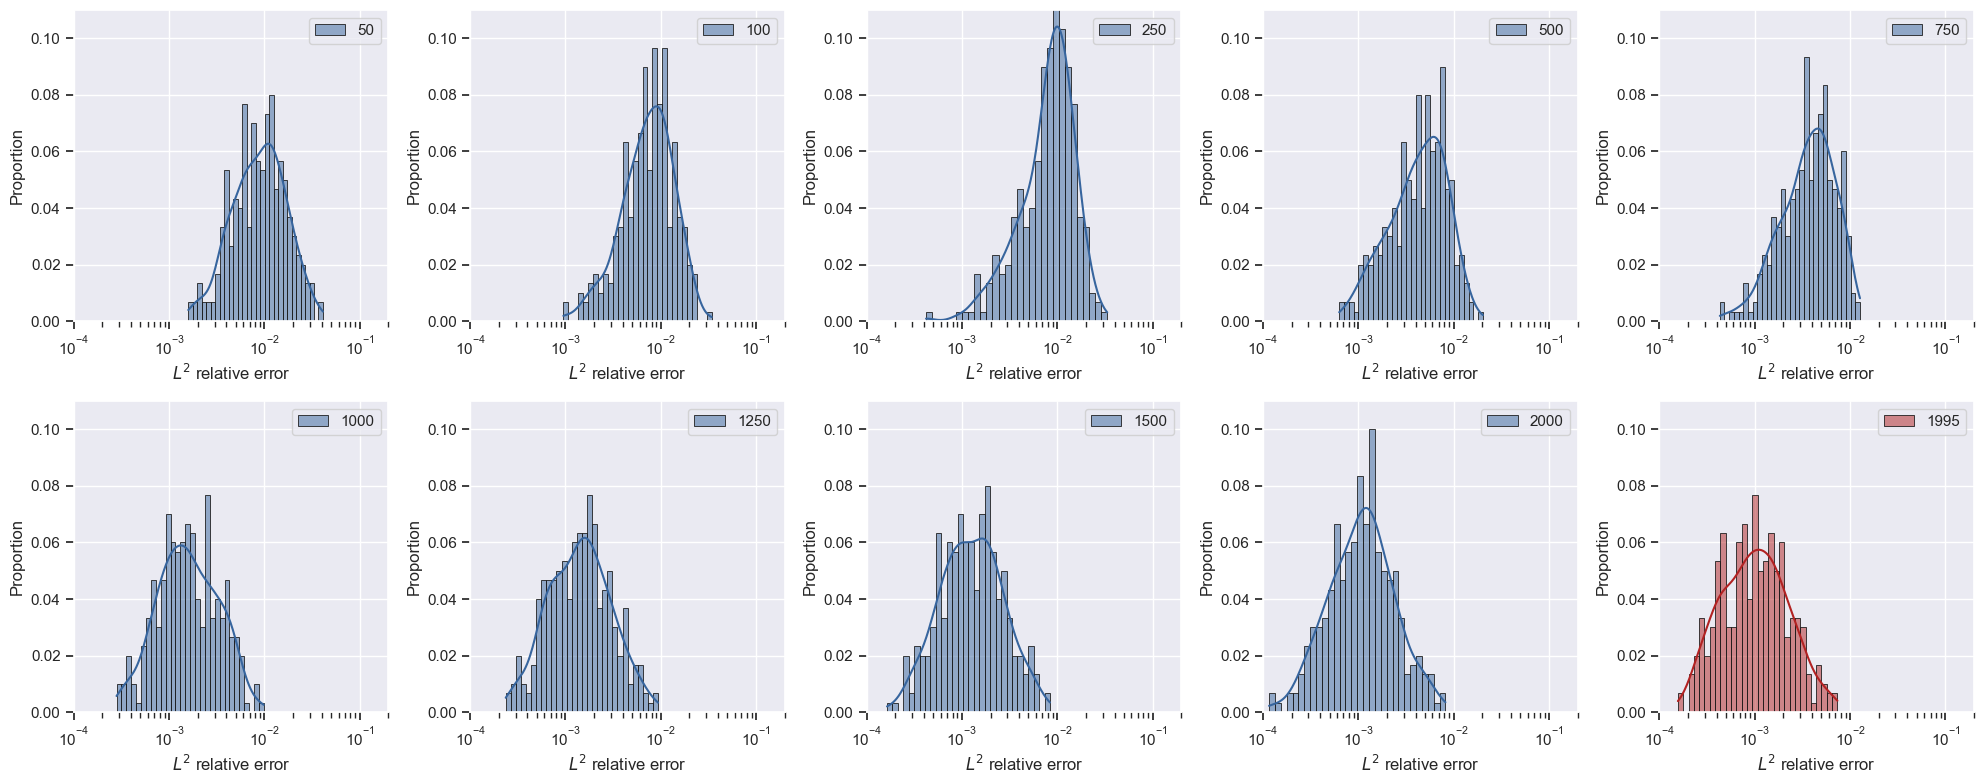

In [7]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1

    if epochs[indices[i]] == best_model["epoch"]:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=L2_errors[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 2e-1)
    axes[j, k].set_ylim(0.0, 0.11)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/histograms_validation_L2.png")
plt.show()

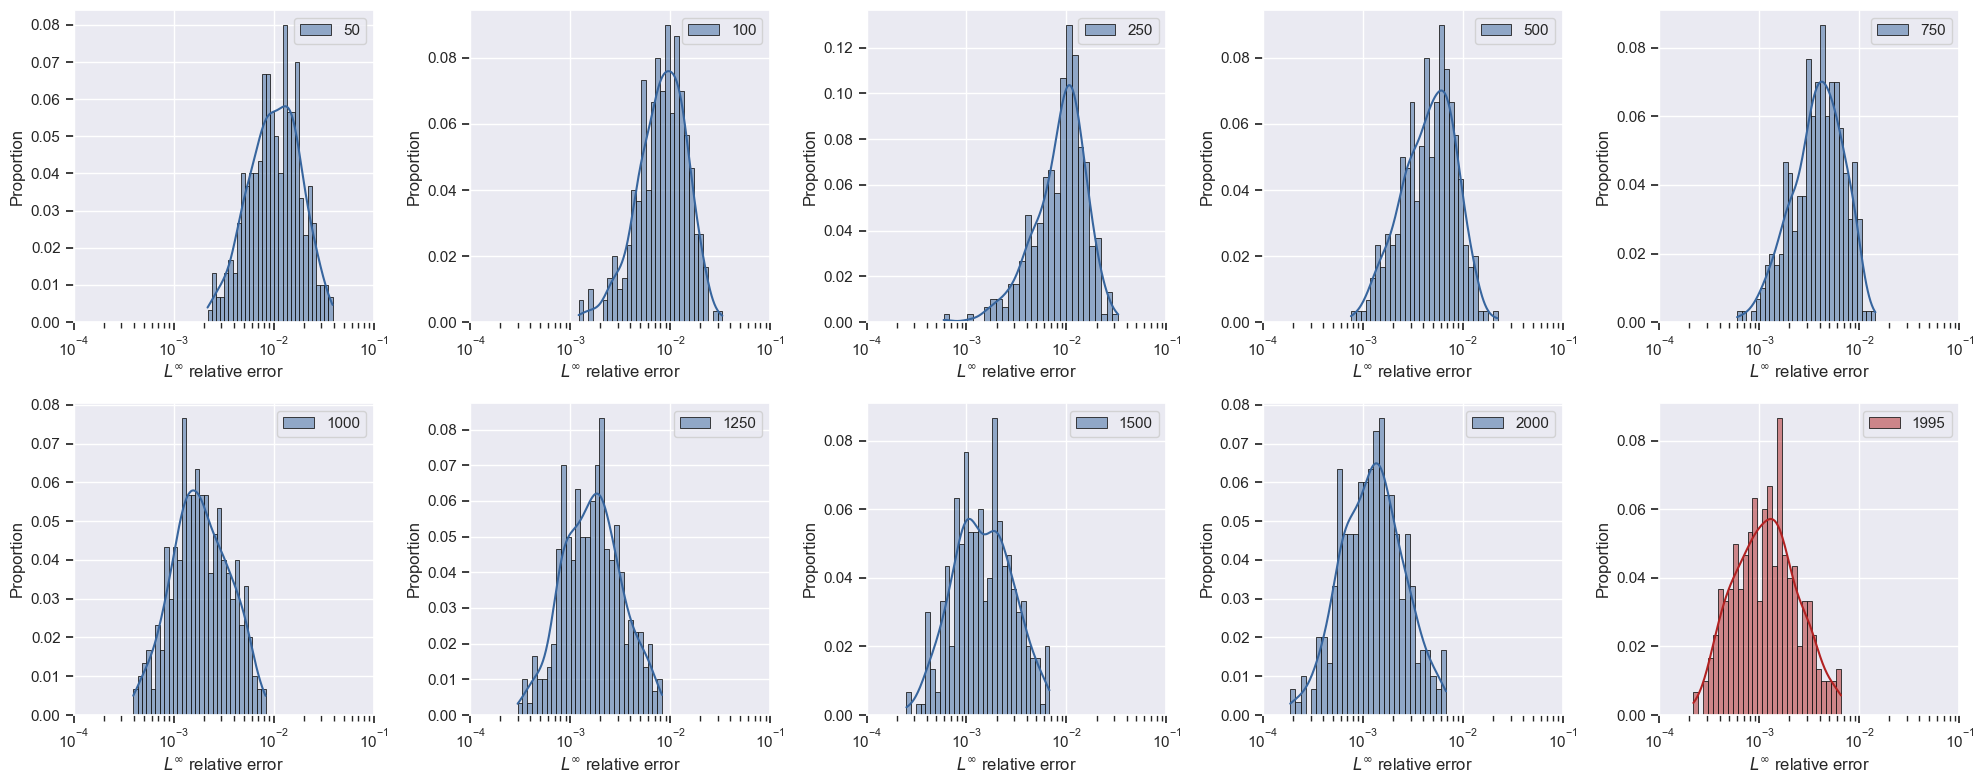

In [8]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1

    if epochs[indices[i]] == best_model["epoch"]:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=Linf_errors[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^\infty$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 1e-1)
    # axes[j, k].set_ylim(0.0, 0.11)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/histograms_validation_Linf.png")
plt.show()

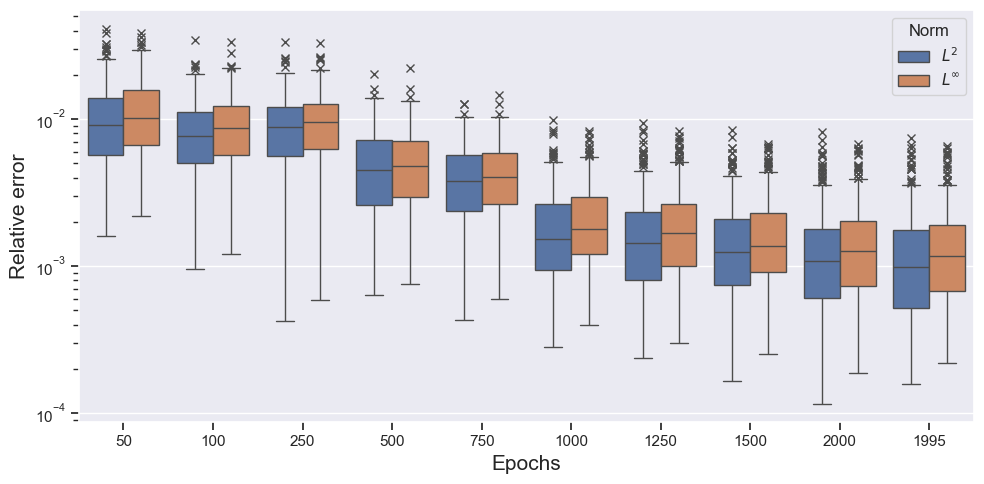

In [9]:
plt.figure(figsize=(10, 5))

size_val = len(L2_errors[0])

epoch_repeat = np.array([])
for epoch in epochs:
    tab = np.repeat(str(epoch), size_val)
    epoch_repeat = np.concatenate([epoch_repeat, tab], axis=0)

tab_L2 = np.repeat(["$L^2$"], size_val * len(epochs))

errors_L2_flatten = np.array(L2_errors).flatten()

df_array_L2 = np.stack([epoch_repeat, errors_L2_flatten, tab_L2], axis=0)

tab_Linf = np.repeat(["$L^\infty$"], size_val * len(epochs))
errors_Linf_flatten = np.array(Linf_errors).flatten()
df_array_Linf = np.stack([epoch_repeat, errors_Linf_flatten, tab_Linf], axis=0)

df_array = np.concatenate([df_array_L2, df_array_Linf], axis=1)

name = ["Epochs", "Error", "Norm"]
df_errors = pd.DataFrame(df_array.transpose(), columns=name)
df_errors = df_errors.astype({"Epochs": "int", "Error": "float64", "Norm": "category"})

sns.boxplot(
    data=df_errors,
    x="Epochs",
    y="Error",
    hue="Norm",
    dodge=True,
    order=epochs,
    flierprops={"marker": "x", "markerfacecolor": "black"},
)
plt.yscale("log")
plt.ylabel("Relative error", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.tight_layout()

if save_figs:
    plt.savefig(f"{images_repo}/boxplots_validation_L2_Linf.png")
plt.show()

(10, 300)


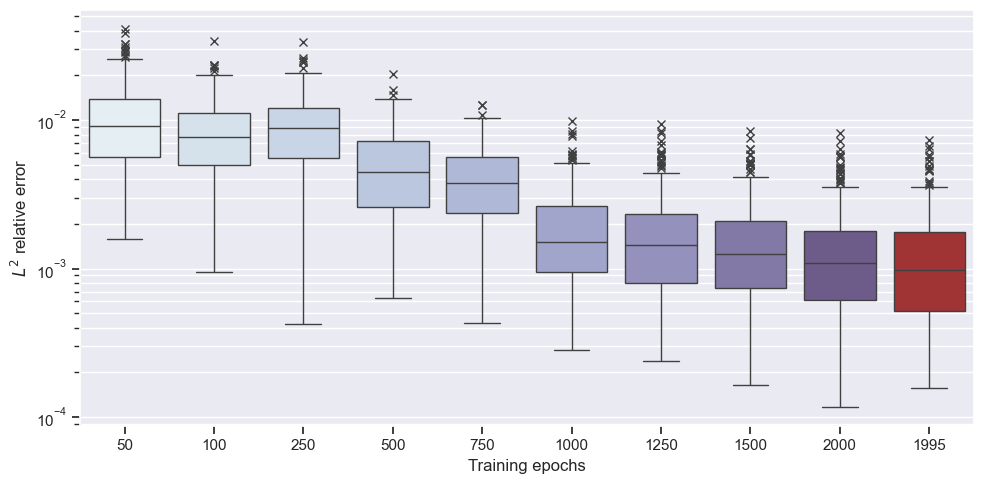

In [10]:
palette = sns.cubehelix_palette(
    n_colors=len(epochs) - 1, start=0.25, rot=-0.25, gamma=0.5
)
palette = palette.as_hex()
palette.insert(-1, "#b22222")
palette = sns.color_palette(palette)

plt.figure(figsize=(10, 5))
errors = np.array(L2_errors[:])
print(np.shape(errors))
dataframe = pd.DataFrame(errors.transpose(), columns=epochs)

sns.boxplot(
    data=dataframe,
    palette=palette,
    order=epochs,
    flierprops={"marker": "x", "markerfacecolor": "black"},
)
plt.xlabel("Training epochs")
plt.ylabel("$L^2$ relative error")
plt.yscale("log")
plt.grid(True, "both", "y")
plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/boxplots_validation_epochs_L2_error.png")
plt.show()

In [11]:
epochs_means = list(i * 40 for i in range(1, 51))
epochs_means.append(best_model["epoch"])

print(len(epochs_means))
print(epochs_means)

L2_errors = []
for i in epochs_means:
    model = None  # clear memory
    X_val, Y_val, x_normed, Y_pred, X_denormed = None, None, None, None, None
    Phi, G, domain, U_true, U_pred = None, None, None, None, None
    error, magnitude = None, None
    gc.collect()
    torch.cuda.empty_cache()  # PyTorch thing
    model = agent.model
    if i != epochs_means[-1]:
        model_i = torch.load(f"{models_repo}/model_{i}.pkl")
        model.load_state_dict(model_i["model_state_dict"])
    else:
        best_model = torch.load(f"{models_repo}/best_model.pkl")
        model.load_state_dict(best_model["model_state_dict"])

    model.eval()
    X_val, Y_val = data.X_val.to(device), data.Y_val.to(device)
    X_val_normed = data.X_val_normed.to(device)
    Y_pred_normed = model(X_val_normed)
    Y_pred = data.y_normalizer.decode(Y_pred_normed)
    Phi, G = X_val[:, 1, :, :], X_val[:, 2, :, :]
    domain = (Phi <= 3e-16).to(device)
    U_true = Y_val[:, 0, :, :] * Phi + G
    U_pred = Y_pred[:, 0, :, :] * Phi + G

    error = compute_L2_norm_squared((U_pred - U_true), domain)
    magnitude = compute_L2_norm_squared((U_true), domain)
    L2_error_i = torch.sqrt(error / magnitude).cpu().detach().numpy()
    L2_errors.append(L2_error_i)
model = None  # clear memory
X_val, Y_val, x_normed, Y_pred, X_denormed = None, None, None, None, None
Phi, G, domain, U_true, U_pred = None, None, None, None, None
error, magnitude, error_inf, magnitude_inf = None, None, None, None
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing

51
[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 1995]


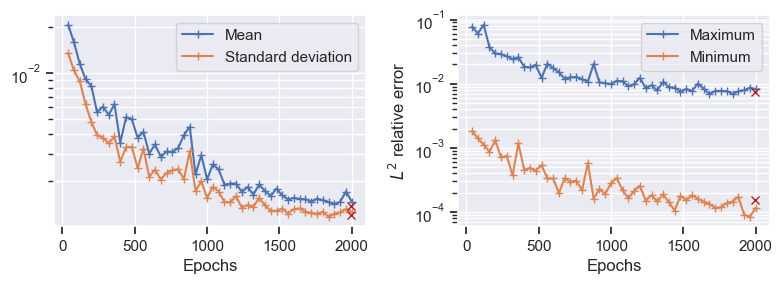

In [12]:
means = np.mean(L2_errors, axis=1)
standard_deviation = np.std(L2_errors, axis=1)
maxs = np.max(L2_errors, axis=1)
mins = np.min(L2_errors, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means[:-1], means[:-1], "-+", label="Mean")
plt.semilogy(
    epochs_means[:-1],
    standard_deviation[:-1],
    "-+",
    label="Standard deviation",
)
plt.semilogy(epochs_means[-1], means[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], standard_deviation[-1], "x", c="firebrick", markersize=6)
plt.xlabel("Epochs")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means[:-1], maxs[:-1], "-+", label="Maximum")
plt.semilogy(epochs_means[:-1], mins[:-1], "-+", label="Minimum")
plt.semilogy(epochs_means[-1], maxs[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], mins[-1], "x", c="firebrick", markersize=6)
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.tight_layout()

if save_figs:
    plt.savefig(f"{images_repo}/min_mean_max_L2_error_epochs.png")
plt.show()

## On a new test dataset

We now move to the case of new data. We generate a new dataset and compute the error between a $\phi$-FEM solution of the dataset and a prediction of the trained model. 

In [13]:
from generate_data import PhiFemSolver
from prepare_data import set_seed

set_seed(150124)

In [22]:
X_test, Y_test, x_normed, Y_pred, X_denormed = None, None, None, None, None
X_val, Y_val = None, None
Phi, G, domain, U_true, U_pred = None, None, None, None, None
error, magnitude, error_inf, magnitude_inf = None, None, None, None
model = None  # clear memory
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing

nb_test_data = 10000
if not os.path.exists(f"./data_test_phi_fem_{nb_test_data}"):
    os.makedirs(f"./data_test_phi_fem_{nb_test_data}")
    F, Phi, G, params = create_FG_numpy(nb_test_data, 64)
    print("Parameters generated")
    solver = PhiFemSolver(nb_cell=64 - 1, params=params)
    W_phi_fem = solver.solve_several()
    X_test = generate_manual_new_data_numpy(F, Phi, G).to(device)

    np.save(f"./data_test_phi_fem_{nb_test_data}/F.npy", F)
    np.save(f"./data_test_phi_fem_{nb_test_data}/agentParams.npy", params)
    np.save(f"./data_test_phi_fem_{nb_test_data}/Phi.npy", Phi)
    np.save(f"./data_test_phi_fem_{nb_test_data}/G.npy", G)
    np.save(f"./data_test_phi_fem_{nb_test_data}/W.npy", W_phi_fem)

In [23]:
X_test, Y_test, x_normed, Y_pred, X_denormed = None, None, None, None, None
Phi, G, domain, U_true, U_pred = None, None, None, None, None
model = None  # clear memory
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing

F, Phi, G = (
    np.load(f"./data_test_phi_fem_{nb_test_data}/F.npy"),
    np.load(f"./data_test_phi_fem_{nb_test_data}/Phi.npy"),
    np.load(f"./data_test_phi_fem_{nb_test_data}/G.npy"),
)
W_phi_fem = np.load(f"./data_test_phi_fem_{nb_test_data}/W.npy")

In [24]:
L2_errors_fno = []
test_batch_size = 500
nb_test_batch = nb_test_data // test_batch_size
print(f"{test_batch_size=}")
print(f"{nb_test_batch=}")

for i in epochs:
    L2_error_i = []
    for j in range(nb_test_batch):
        print(f"Epoch = {i} Batch : {j} / {nb_test_batch}")
        X_test, Y_test, x_normed, Y_pred, X_denormed = None, None, None, None, None
        domain, U_true, U_pred = None, None, None
        X_test_normed_j, Y_pred_normed_j, Y_pred, Phi_batch, Y_test_batch, G_batch = (
            None,
            None,
            None,
            None,
            None,
            None,
        )
        error, magnitude, error_inf, magnitude_inf = None, None, None, None
        model = None  # clear memory
        gc.collect()
        torch.cuda.empty_cache()  # PyTorch thing
        # F, Phi, G = np.load('./data_test_phi_fem/F.npy'), np.load('./data_test_phi_fem/Phi.npy'), np.load('./data_test_phi_fem/G.npy')
        # W_phi_fem = np.load('./data_test_phi_fem/W.npy')
        model = agent.model
        if i != epochs[-1]:
            model_i = torch.load(f"{models_repo}/model_{i}.pkl")
            model.load_state_dict(model_i["model_state_dict"])
        else:
            best_model = torch.load(f"{models_repo}/best_model.pkl")
            model.load_state_dict(best_model["model_state_dict"])
        model.eval()
        sli = slice(j * test_batch_size, (j + 1) * test_batch_size)
        X_test = generate_manual_new_data_numpy(F[sli], Phi[sli], G[sli]).to(device)
        X_test_normed_j = data.x_normalizer.encode(X_test)
        Y_pred_normed_j = model(X_test_normed_j)
        Y_pred = data.y_normalizer.decode(Y_pred_normed_j)

        Phi_batch, G_batch = X_test[:, 1, :, :], X_test[:, 2, :, :]
        domain = (Phi_batch <= 3e-16).to(device)
        Y_test_batch = torch.tensor(W_phi_fem[sli, None, :, :]).to(device)
        U_true = Y_test_batch[:, 0, :, :] * Phi_batch + G_batch
        U_pred = Y_pred[:, 0, :, :] * Phi_batch + G_batch

        error = compute_L2_norm_squared((U_pred - U_true), domain)
        magnitude = compute_L2_norm_squared((U_true), domain)
        L2_error_batch = torch.sqrt(error / magnitude).cpu().detach().numpy()
        L2_error_i.append(L2_error_batch)
    L2_error_i = np.array(L2_error_i)
    L2_errors_fno.append(L2_error_i.flatten())

L2_errors_fno = np.array(L2_errors_fno)
print(L2_errors_fno.shape)

test_batch_size=500
nb_test_batch=20
Epoch = 50 Batch : 0 / 20
Epoch = 50 Batch : 1 / 20
Epoch = 50 Batch : 2 / 20
Epoch = 50 Batch : 3 / 20
Epoch = 50 Batch : 4 / 20
Epoch = 50 Batch : 5 / 20
Epoch = 50 Batch : 6 / 20
Epoch = 50 Batch : 7 / 20
Epoch = 50 Batch : 8 / 20
Epoch = 50 Batch : 9 / 20
Epoch = 50 Batch : 10 / 20
Epoch = 50 Batch : 11 / 20
Epoch = 50 Batch : 12 / 20
Epoch = 50 Batch : 13 / 20
Epoch = 50 Batch : 14 / 20
Epoch = 50 Batch : 15 / 20
Epoch = 50 Batch : 16 / 20
Epoch = 50 Batch : 17 / 20
Epoch = 50 Batch : 18 / 20
Epoch = 50 Batch : 19 / 20
Epoch = 100 Batch : 0 / 20
Epoch = 100 Batch : 1 / 20
Epoch = 100 Batch : 2 / 20
Epoch = 100 Batch : 3 / 20
Epoch = 100 Batch : 4 / 20
Epoch = 100 Batch : 5 / 20
Epoch = 100 Batch : 6 / 20
Epoch = 100 Batch : 7 / 20
Epoch = 100 Batch : 8 / 20
Epoch = 100 Batch : 9 / 20
Epoch = 100 Batch : 10 / 20
Epoch = 100 Batch : 11 / 20
Epoch = 100 Batch : 12 / 20
Epoch = 100 Batch : 13 / 20
Epoch = 100 Batch : 14 / 20
Epoch = 100 Batch : 15 

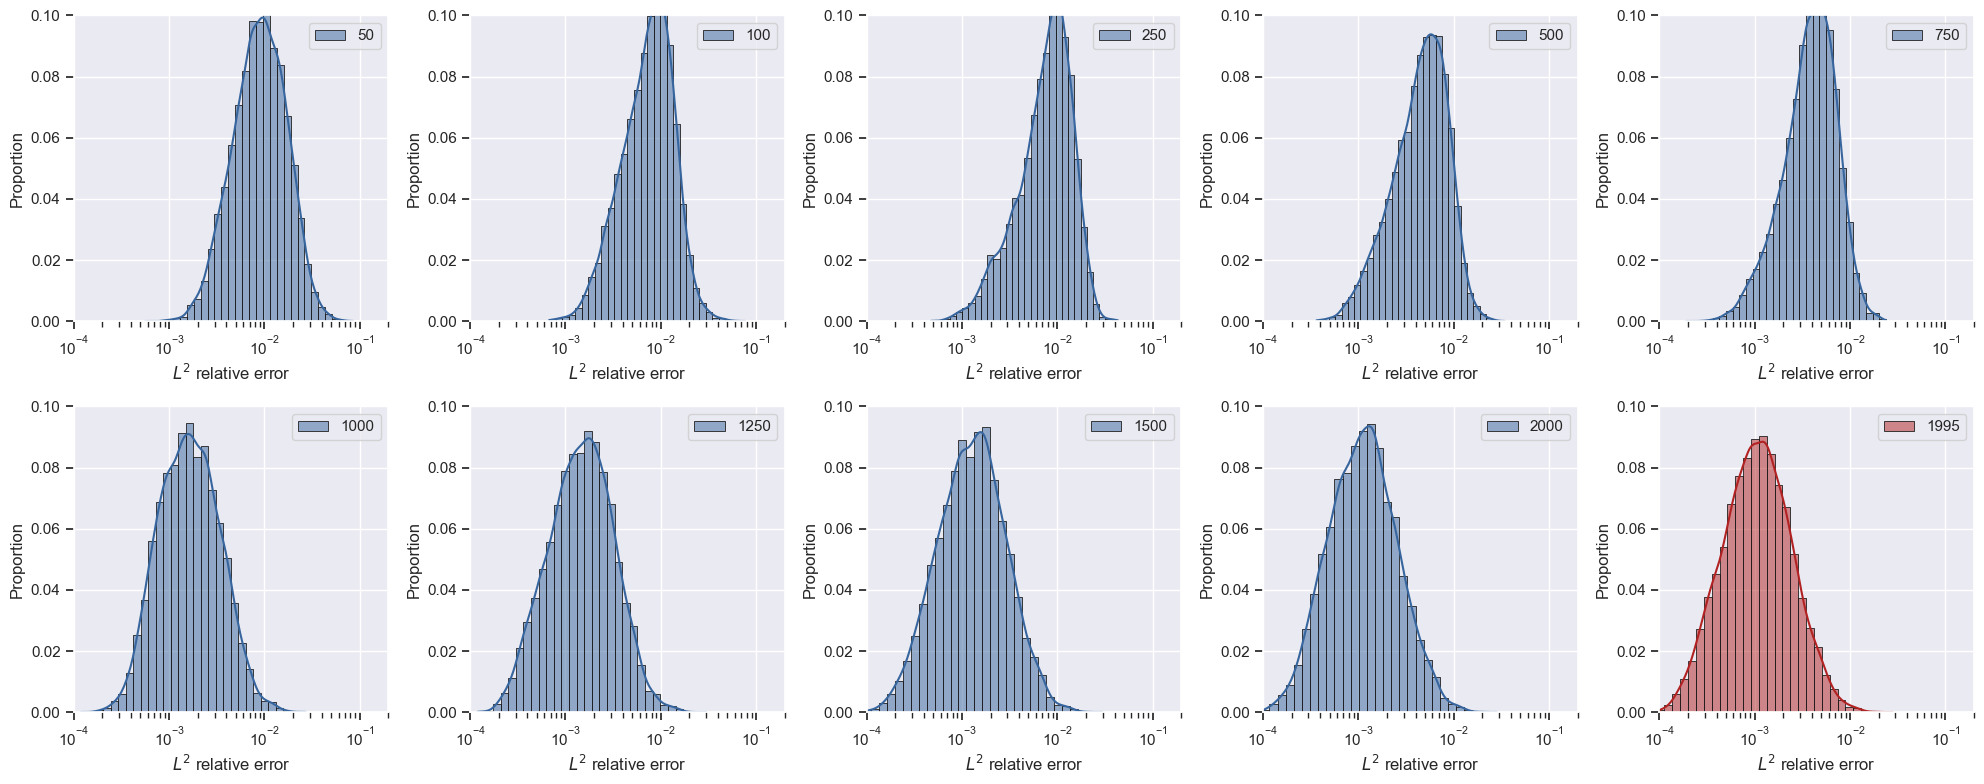

In [25]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    if epochs[indices[i]] == epochs[-1]:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=L2_errors_fno[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 2e-1)
    axes[j, k].set_ylim(0.0, 0.10)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/histograms_new_data_L2.png")
plt.show()

(10, 10000)


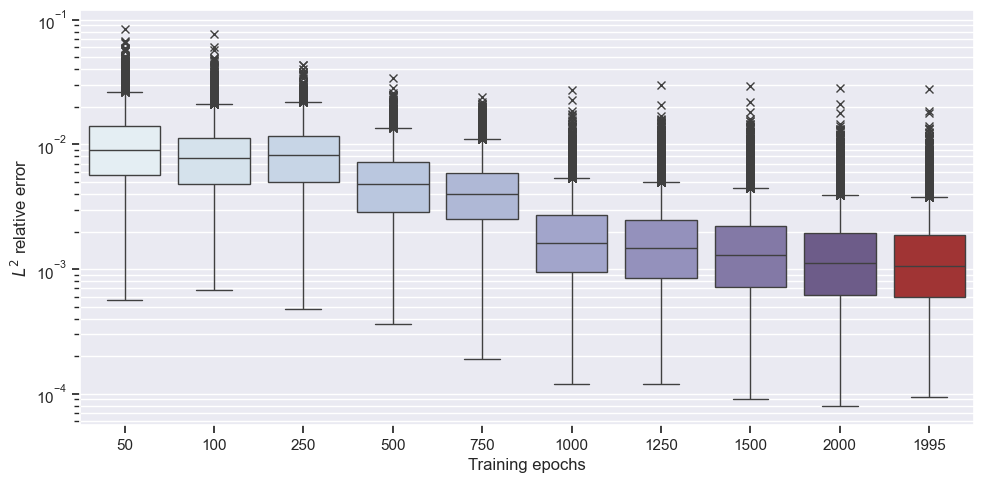

In [26]:
palette = sns.cubehelix_palette(
    n_colors=len(epochs) - 1, start=0.25, rot=-0.25, gamma=0.5
)
palette = palette.as_hex()
palette.insert(-1, "#b22222")
palette = sns.color_palette(palette)

plt.figure(figsize=(10, 5))
errors_fno = np.array(L2_errors_fno[:])
print(np.shape(errors_fno))
dataframe = pd.DataFrame(errors_fno.transpose(), columns=epochs)

sns.boxplot(
    data=dataframe,
    palette=palette,
    order=epochs,
    flierprops={"marker": "x", "markerfacecolor": "black"},
)
plt.xlabel("Training epochs")
plt.ylabel("$L^2$ relative error")
plt.yscale("log")
plt.grid(True, "both", "y")
plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/boxplots_new_data_L2.png")
plt.show()

In [27]:
L2_errors_fno = []
L_inf_errors_fno = []
test_batch_size = 500
nb_test_batch = nb_test_data // test_batch_size
print(f"{test_batch_size=}")
print(f"{nb_test_batch=}")

for i in epochs_means:
    L2_error_i = []
    L_inf_error_i = []
    for j in range(nb_test_batch):
        print(f"Epoch = {i} Batch : {j} / {nb_test_batch}")
        X_test, Y_test, x_normed, Y_pred, X_denormed = None, None, None, None, None
        domain, U_true, U_pred = None, None, None
        X_test_normed_j, Y_pred_normed_j, Y_pred, Phi_batch, Y_test_batch, G_batch = (
            None,
            None,
            None,
            None,
            None,
            None,
        )
        error, magnitude, error_inf, magnitude_inf = None, None, None, None
        model = None  # clear memory
        gc.collect()
        torch.cuda.empty_cache()  # PyTorch thing
        model = agent.model
        if i != epochs[-1]:
            model_i = torch.load(f"{models_repo}/model_{i}.pkl")
            model.load_state_dict(model_i["model_state_dict"])
        else:
            best_model = torch.load(f"{models_repo}/best_model.pkl")
            model.load_state_dict(best_model["model_state_dict"])
        model.eval()
        sli = slice(j * test_batch_size, (j + 1) * test_batch_size)
        X_test = generate_manual_new_data_numpy(F[sli], Phi[sli], G[sli]).to(device)
        X_test_normed_j = data.x_normalizer.encode(X_test)
        Y_pred_normed_j = model(X_test_normed_j)
        Y_pred = data.y_normalizer.decode(Y_pred_normed_j)

        Phi_batch, G_batch = X_test[:, 1, :, :], X_test[:, 2, :, :]
        domain = (Phi_batch <= 3e-16).to(device)
        Y_test_batch = torch.tensor(W_phi_fem[sli, None, :, :]).to(device)
        U_true = Y_test_batch[:, 0, :, :] * Phi_batch + G_batch
        U_pred = Y_pred[:, 0, :, :] * Phi_batch + G_batch

        error = compute_L2_norm_squared((U_pred - U_true), domain)
        magnitude = compute_L2_norm_squared((U_true), domain)
        L2_error_batch = torch.sqrt(error / magnitude).cpu().detach().numpy()
        L2_error_i.append(L2_error_batch)

        error_inf = compute_Linf_norm((U_pred - U_true), domain)
        magnitude_inf = compute_Linf_norm((U_true), domain)
        L_inf_error_batch = (error_inf / magnitude_inf).cpu().detach().numpy()
        L_inf_error_i.append(L_inf_error_batch)

    L2_error_i = np.array(L2_error_i)
    L2_errors_fno.append(L2_error_i.flatten())
    L_inf_error_i = np.array(L_inf_error_i)
    L_inf_errors_fno.append(L_inf_error_i.flatten())

L2_errors_fno = np.array(L2_errors_fno)
L_inf_errors_fno = np.array(L_inf_errors_fno)

print(L2_errors_fno.shape)
print(L_inf_errors_fno.shape)

test_batch_size=500
nb_test_batch=20
Epoch = 40 Batch : 0 / 20
Epoch = 40 Batch : 1 / 20
Epoch = 40 Batch : 2 / 20
Epoch = 40 Batch : 3 / 20
Epoch = 40 Batch : 4 / 20
Epoch = 40 Batch : 5 / 20
Epoch = 40 Batch : 6 / 20
Epoch = 40 Batch : 7 / 20
Epoch = 40 Batch : 8 / 20
Epoch = 40 Batch : 9 / 20
Epoch = 40 Batch : 10 / 20
Epoch = 40 Batch : 11 / 20
Epoch = 40 Batch : 12 / 20
Epoch = 40 Batch : 13 / 20
Epoch = 40 Batch : 14 / 20
Epoch = 40 Batch : 15 / 20
Epoch = 40 Batch : 16 / 20
Epoch = 40 Batch : 17 / 20
Epoch = 40 Batch : 18 / 20
Epoch = 40 Batch : 19 / 20
Epoch = 80 Batch : 0 / 20
Epoch = 80 Batch : 1 / 20
Epoch = 80 Batch : 2 / 20
Epoch = 80 Batch : 3 / 20
Epoch = 80 Batch : 4 / 20
Epoch = 80 Batch : 5 / 20
Epoch = 80 Batch : 6 / 20
Epoch = 80 Batch : 7 / 20
Epoch = 80 Batch : 8 / 20
Epoch = 80 Batch : 9 / 20
Epoch = 80 Batch : 10 / 20
Epoch = 80 Batch : 11 / 20
Epoch = 80 Batch : 12 / 20
Epoch = 80 Batch : 13 / 20
Epoch = 80 Batch : 14 / 20
Epoch = 80 Batch : 15 / 20
Epoch = 80 

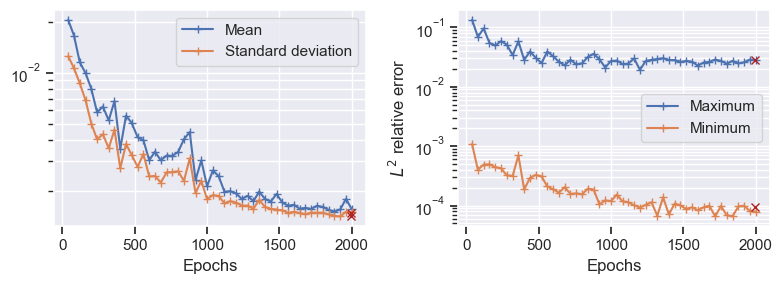

In [28]:
means = np.mean(L2_errors_fno, axis=1)
standard_deviation = np.std(L2_errors_fno, axis=1)
maxs = np.max(L2_errors_fno, axis=1)
mins = np.min(L2_errors_fno, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means[:-1], means[:-1], "-+", label="Mean")
plt.semilogy(
    epochs_means[:-1],
    standard_deviation[:-1],
    "-+",
    label="Standard deviation",
)
plt.semilogy(epochs_means[-1], means[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], standard_deviation[-1], "x", c="firebrick", markersize=6)
plt.xlabel("Epochs")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means[:-1], maxs[:-1], "-+", label="Maximum")
plt.semilogy(epochs_means[:-1], mins[:-1], "-+", label="Minimum")
plt.semilogy(epochs_means[-1], maxs[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], mins[-1], "x", c="firebrick", markersize=6)
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")

plt.tight_layout()

if save_figs:
    plt.savefig(f"{images_repo}/min_mean_max_L2_error_epochs_new_data.png")
plt.show()

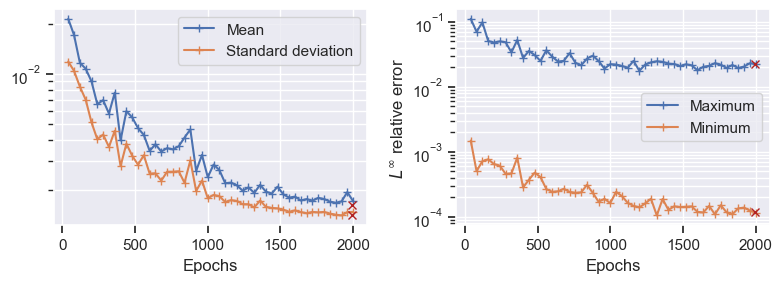

In [29]:
means_linf = np.mean(L_inf_errors_fno, axis=1)
standard_deviation_linf = np.std(L_inf_errors_fno, axis=1)
maxs_linf = np.max(L_inf_errors_fno, axis=1)
mins_linf = np.min(L_inf_errors_fno, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means[:-1], means_linf[:-1], "-+", label="Mean")
plt.semilogy(
    epochs_means[:-1],
    standard_deviation_linf[:-1],
    "-+",
    label="Standard deviation",
)
plt.semilogy(epochs_means[-1], means_linf[-1], "x", c="firebrick", markersize=6)
plt.semilogy(
    epochs_means[-1], standard_deviation_linf[-1], "x", c="firebrick", markersize=6
)
plt.xlabel("Epochs")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means[:-1], maxs_linf[:-1], "-+", label="Maximum")
plt.semilogy(epochs_means[:-1], mins_linf[:-1], "-+", label="Minimum")
plt.semilogy(epochs_means[-1], maxs_linf[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], mins_linf[-1], "x", c="firebrick", markersize=6)
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^\infty$ relative error")

plt.tight_layout()

if save_figs:
    plt.savefig(f"{images_repo}/min_mean_max_Linf_error_epochs_new_data.png")
plt.show()